# **ML Final Project**
### 1971063 김윤서   

#### • Task 1: Implement Inception module for CIFAIR-10. (20 points)
#### • Task 2: Increase your Test set accuracy. (25 points)
#### • Task 3: Find hyper-parameters. (25 points)
#### • Task 4: Write report: (30 points)



## 기존 코드 (AS0)

## 0. Load datasets

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size= 4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size= 4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [4]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

(36, 138, 3)


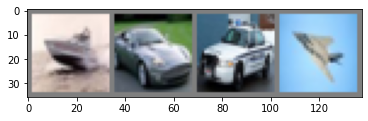

 ship   car   car plane
torch.Size([3, 32, 32])


In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)

### 학습 결과 분석을 위한 그래프 구현

In [8]:

import matplotlib.pyplot as plt

def plot_acc(history, title=None):
  # summarize history for accuracy
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  if title is not None:
    plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)   # 두 선의 이름(Train, Test) 표시

def plot_loss(history, title=None):
  # summarize history for loss
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['loss'])             # 학습 데이터로 구한 손실값
  plt.plot(history['val_loss'])         # 검증 데이터로 구한 손실값
  if title is not None:
    plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)

## 1. Training a small CNN model

#### CNN architecture in order:
* 5x5 Convolutional layer with 6 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* 5x5 Convolutional layer with 16 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* Fully connected layer with 120 output units and ReLU activation
* Fully connected layer with 84 output units and ReLU activation
* Fully connected layer with 10 output units and linear activation
* You can use any padding option.

#### Training setup:
* Loss function: Sotfmax cross entropy
* Optimizer: Gradient descent with 0.001 learning rate
* Batch size: 4
* Training epoch: 2

In [10]:
# Define a CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # 추가한 코드
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = Net()

In [11]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [12]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
# Function to train the network

def train(net, trainloader, max_epoch, crit, opt, model_path='./cifar_net.pth'):

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            # Training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [18]:
PATH = './cifar_net.pth'
epoch = 2
train(net, trainloader, epoch, criterion, optimizer, PATH)


[1,  2000] loss: 1.198
[1,  4000] loss: 1.183
[1,  6000] loss: 1.183
[1,  8000] loss: 1.175
[1, 10000] loss: 1.157
[1, 12000] loss: 1.146
[2,  2000] loss: 1.087
[2,  4000] loss: 1.073
[2,  6000] loss: 1.102
[2,  8000] loss: 1.074
[2, 10000] loss: 1.073
[2, 12000] loss: 1.071
Finished Training
Saved Trained Model


In [19]:
# function to calculate accuracy
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))

In [20]:
# 정확도 출력
print_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 58 %


In [21]:
# 시각화
#plot_acc(history)
#plt.show()

# Task 1: Implement Inception module for CIFAR-10.

In [22]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

# CNN model 정의

In [29]:
# Define a CNN model
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()

        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)
      
      
    def forward(self, x):
        
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

In [30]:
googlenet = GoogLeNet()
googlenet = googlenet.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)

PATH = './google_net.pth'

# Train
train(googlenet, trainloader, 2, criterion, optimizer, PATH)

[1,  2000] loss: 1.896
[1,  4000] loss: 1.560
[1,  6000] loss: 1.388
[1,  8000] loss: 1.223
[1, 10000] loss: 1.138
[1, 12000] loss: 1.066
[2,  2000] loss: 0.921
[2,  4000] loss: 0.892
[2,  6000] loss: 0.866
[2,  8000] loss: 0.797
[2, 10000] loss: 0.794
[2, 12000] loss: 0.737
Finished Training
Saved Trained Model


In [31]:

# Test
googlenet.load_state_dict(torch.load(PATH))
print_accuracy(googlenet, testloader)

Accuracy of the network on the 10000 test images: 74 %


# GoogleNet 보완해보기 -> MyNet

In [33]:
# Define a CNN model
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )

        self.a3 = Inception(128,  32,  48,  64,  8, 16, 16)
        self.b3 = Inception(128,  64,  96, 128, 16, 32, 32)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(256, 160,  96, 256, 16,  64,  64)
        self.b4 = Inception(544, 256, 128, 256, 64, 128, 128)
        self.c4 = Inception(768, 256, 128, 256, 64, 128, 128)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a5 = Inception(768, 256, 256, 512, 64, 128, 128)
        self.b5 = Inception(1024, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)
        

    def forward(self, x):
        
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

In [34]:

myNet = MyNet()
myNet = myNet.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9)

PATH = './my_net.pth'

# Train
train(myNet, trainloader, 2, criterion, optimizer, PATH)

[1,  2000] loss: 1.853
[1,  4000] loss: 1.514
[1,  6000] loss: 1.327
[1,  8000] loss: 1.168
[1, 10000] loss: 1.084
[1, 12000] loss: 0.970
[2,  2000] loss: 0.898
[2,  4000] loss: 0.849
[2,  6000] loss: 0.816
[2,  8000] loss: 0.785
[2, 10000] loss: 0.752
[2, 12000] loss: 0.720
Finished Training
Saved Trained Model


In [36]:
# Test
myNet.load_state_dict(torch.load(PATH))
print_accuracy(myNet, testloader)

Accuracy of the network on the 10000 test images: 76 %
